# AutoPhaseNN
#### Pytorch version (under development)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn

from torchinfo import summary
from tqdm.notebook import tqdm 
import numpy as np

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
import matplotlib

import params
from data_loader import *

In [2]:
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * params.BATCH_SIZE_PER_GPU 
LR = NGPUS * params.BASE_LR
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

SW_INCREMENT = (params.FINAL_SW-params.INIT_SW)/(params.EPOCHS-1-params.CONST_EPOCHS)
print("SW Thresh increment", SW_INCREMENT)

GPUs: 1 Batch size: 128 Learning rate: 0.0004
SW Thresh increment 0.0005084745762711864


### Plotting

In [3]:
plt.style.use('seaborn-v0_8-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()
%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [4]:
def plot6(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3", "Plot4", "Plot5", "Plot6"]
    ind = data[0].shape[0]//2
    fig, axes = plt.subplots(1,6, figsize=(19,3), constrained_layout=True)
    for ix, ax in enumerate(axes):
        im=ax.imshow(data[ix][ind])
        plt.colorbar(im, ax=ax)
        ax.set_title(titles[ix])

### Load and check data, then prepare as tensors

In [5]:
# # data loader

dataname_list = os.path.join(params.data_path, '3D_upsamp.txt')
filelist = []

with open(dataname_list, 'r') as f:
    txtfile = f.readlines()
for i in range(len(txtfile)):
    tmp = str(txtfile[i]).split('/')[-1]
    tmp = tmp.split('\n')[0]

    filelist.append(tmp)
f.close()
print('number of available file:%d' % len(filelist))

# give training data size and filelist
# train_file_indxs = np.random.randint(len(filelist), size=N_TRAIN).astype('int')
# train_filelist = [filelist[idx] for idx in train_file_indxs]
train_filelist = filelist[:params.N_TRAIN]
print('number of training:%d' % len(train_filelist))


number of available file:54028
number of training:50000


In [6]:
# load training data and validation data
train_dataset = Dataset(
    train_filelist, params.data_path, load_all=False, 
    ratio=params.TRAIN_ratio, dataset='train',scale_I=params.scale_I)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NGPUS*4)
# train_sampler = DistributedSampler(
#     train_dataset, num_replicas=NGPUS, rank=rank, shuffle=True)
# train_loader = DataLoader(
#     train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False, num_workers=NGPUS*8)


validation_dataset = Dataset(
    train_filelist, params.data_path, load_all=False, ratio=params.TRAIN_ratio, 
    dataset='validation',scale_I=params.scale_I)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NGPUS*4)
# validation_sampler = DistributedSampler(
#     validation_dataset, num_replicas=NGPUS, rank=rank, shuffle=True)
# validation_loader = DataLoader(
#     validation_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler, shuffle=False, num_workers=NGPUS*8)

### Check the model works

In [7]:
from model import recon_model

In [8]:
model = recon_model()
for ft_images,amps,phs in train_loader:
    print("batch size:", ft_images.shape, amps.shape, phs.shape)
    #outs = model(ft_images)
    #print(*[o.shape for o in outs])
    #print(*[o.dtype for o in outs])
    y, complex_x, amp, ph, _ = model(ft_images)
    print(y.shape, complex_x.shape, amp.shape, ph.shape)
    print(y.dtype, complex_x.dtype, amp.dtype, ph.dtype)
    break

batch size: torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64])
torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64])
torch.float32 torch.complex64 torch.float32 torch.float32


In [9]:
summary(model, (1, 1, 64,64,64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
recon_model                              [1, 1, 64, 64, 64]        --
├─Sequential: 1-1                        [1, 256, 4, 4, 4]         --
│    └─Conv3d: 2-1                       [1, 32, 64, 64, 64]       896
│    └─LeakyReLU: 2-2                    [1, 32, 64, 64, 64]       --
│    └─BatchNorm3d: 2-3                  [1, 32, 64, 64, 64]       64
│    └─Conv3d: 2-4                       [1, 64, 32, 32, 32]       55,360
│    └─LeakyReLU: 2-5                    [1, 64, 32, 32, 32]       --
│    └─BatchNorm3d: 2-6                  [1, 64, 32, 32, 32]       128
│    └─Conv3d: 2-7                       [1, 64, 32, 32, 32]       110,656
│    └─LeakyReLU: 2-8                    [1, 64, 32, 32, 32]       --
│    └─BatchNorm3d: 2-9                  [1, 64, 32, 32, 32]       128
│    └─Conv3d: 2-10                      [1, 128, 16, 16, 16]      221,312
│    └─LeakyReLU: 2-11                   [1, 128, 16, 16, 16]      -

### Move model to appropriate device

In [10]:
model = recon_model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if NGPUS > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

### Setup optimizer and cyclicLR

In [11]:
#Optimizer details
iterations_per_epoch = np.floor((params.N_TRAIN*params.TRAIN_ratio)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LR) #Adam with weight decay
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR, 
                                              max_lr=LR*5, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 2112.0 which is every 6 epochs


## Training and Validation Loop

In [12]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if NGPUS > 1:
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model.state_dict(),path+'best_model.pth')

In [13]:
def train(trainloader,metrics):
    loss_ft = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        y, _, pred_amps, pred_phs, support = model(ft_images) #Forward pass
        
        #Compute losses
        loss_f = criterion(y, ft_images)
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs*support,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_f #Use only FT loss for gradients
        #loss = loss_a + loss_p + loss_f

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        loss_ft += loss_f.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()
        #loss_ft = 0

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([loss_ft/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    val_loss_ft = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        y, _, pred_amps, pred_phs, support = model(ft_images) #Forward pass
        #pred_amps, pred_phs, support = model(ft_images) #Forward pass
    
        val_loss_f = criterion(y, ft_images)
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs*support,phs) 
    
        val_loss_ft += val_loss_f.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
        
    metrics['val_losses'].append([val_loss_ft/j,val_loss_amp/j,val_loss_ph/j])
    
  #Update saved model if val loss is lower
    if(val_loss_ft/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],val_loss_ft/j))
        metrics['best_val_loss'] = val_loss_ft/j
        update_saved_model(model, params.MODEL_SAVE_PATH)

In [14]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

for epoch in tqdm(range(params.EPOCHS)):
    
    #Set model to train mode
    model.train() 

    #Training loop
    train(train_loader,metrics)

    #Switch model to eval mode
    model.eval()

#     Validation loop
    validate(validation_loader,metrics)
    l = metrics['losses'][-1]
    lv =  metrics['val_losses'][-1]

    print(f'Epoch: {epoch} | FT  | Train Loss: {l[0]:.5f} | Val Loss: {lv[0]:.5f}')
    print(f'Epoch: {epoch} | Amp | Train Loss: {l[1]:.4f} | Val Loss: {lv[1]:.5f}')
    print(f'Epoch: {epoch} | Ph  | Train Loss: {l[2]:.3f} | Val Loss: {lv[2]:.5f}')
    if NGPUS>1:
        print(f'Epoch: {epoch} | SW Thresh: {model.module.sw_thresh:.4f}')
    else:
        print(f'Epoch: {epoch} | SW Thresh: {model.sw_thresh:.4f}')
           
    print(f'Epoch: {epoch} | Ending LR: {metrics["lrs"][-1][0]:.6f}')

    if(epoch>=(params.CONST_EPOCHS-1)): #Keep SW thresh =0 i.e fixed half box support for first N epochs
        if NGPUS>1:
            model.module.sw_thresh+=SW_INCREMENT #Update shrink-wrap threshold every epoch
        else:
            model.sw_thresh+=SW_INCREMENT #Update shrink-wrap threshold every epoch

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saving improved model after Val Loss improved from inf to 0.00167
Epoch: 0 | FT  | Train Loss: 0.00176 | Val Loss: 0.00167
Epoch: 0 | Amp | Train Loss: 0.0312 | Val Loss: 0.02590
Epoch: 0 | Ph  | Train Loss: 0.070 | Val Loss: 0.04317
Epoch: 0 | SW Thresh: 0.0700
Epoch: 0 | Ending LR: 0.000667


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00167 to 0.00150
Epoch: 1 | FT  | Train Loss: 0.00148 | Val Loss: 0.00150
Epoch: 1 | Amp | Train Loss: 0.0229 | Val Loss: 0.02263
Epoch: 1 | Ph  | Train Loss: 0.033 | Val Loss: 0.03329
Epoch: 1 | SW Thresh: 0.0705
Epoch: 1 | Ending LR: 0.000933


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00150 to 0.00148
Epoch: 2 | FT  | Train Loss: 0.00143 | Val Loss: 0.00148
Epoch: 2 | Amp | Train Loss: 0.0226 | Val Loss: 0.02179
Epoch: 2 | Ph  | Train Loss: 0.030 | Val Loss: 0.03120
Epoch: 2 | SW Thresh: 0.0710
Epoch: 2 | Ending LR: 0.001200


0it [00:00, ?it/s]

Epoch: 3 | FT  | Train Loss: 0.00140 | Val Loss: 0.00149
Epoch: 3 | Amp | Train Loss: 0.0223 | Val Loss: 0.02295
Epoch: 3 | Ph  | Train Loss: 0.029 | Val Loss: 0.03066
Epoch: 3 | SW Thresh: 0.0715
Epoch: 3 | Ending LR: 0.001467


0it [00:00, ?it/s]

Epoch: 4 | FT  | Train Loss: 0.00138 | Val Loss: 0.00149
Epoch: 4 | Amp | Train Loss: 0.0218 | Val Loss: 0.02178
Epoch: 4 | Ph  | Train Loss: 0.028 | Val Loss: 0.02690
Epoch: 4 | SW Thresh: 0.0720
Epoch: 4 | Ending LR: 0.001733


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00148 to 0.00143
Epoch: 5 | FT  | Train Loss: 0.00136 | Val Loss: 0.00143
Epoch: 5 | Amp | Train Loss: 0.0213 | Val Loss: 0.02173
Epoch: 5 | Ph  | Train Loss: 0.027 | Val Loss: 0.02832
Epoch: 5 | SW Thresh: 0.0725
Epoch: 5 | Ending LR: 0.002000


0it [00:00, ?it/s]

Epoch: 6 | FT  | Train Loss: 0.00134 | Val Loss: 0.00146
Epoch: 6 | Amp | Train Loss: 0.0205 | Val Loss: 0.02020
Epoch: 6 | Ph  | Train Loss: 0.026 | Val Loss: 0.02794
Epoch: 6 | SW Thresh: 0.0731
Epoch: 6 | Ending LR: 0.001733


0it [00:00, ?it/s]

Epoch: 7 | FT  | Train Loss: 0.00133 | Val Loss: 0.00148
Epoch: 7 | Amp | Train Loss: 0.0191 | Val Loss: 0.02028
Epoch: 7 | Ph  | Train Loss: 0.025 | Val Loss: 0.02844
Epoch: 7 | SW Thresh: 0.0736
Epoch: 7 | Ending LR: 0.001467


0it [00:00, ?it/s]

Epoch: 8 | FT  | Train Loss: 0.00129 | Val Loss: 0.00155
Epoch: 8 | Amp | Train Loss: 0.0163 | Val Loss: 0.01313
Epoch: 8 | Ph  | Train Loss: 0.022 | Val Loss: 0.01867
Epoch: 8 | SW Thresh: 0.0741
Epoch: 8 | Ending LR: 0.001200


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00143 to 0.00134
Epoch: 9 | FT  | Train Loss: 0.00127 | Val Loss: 0.00134
Epoch: 9 | Amp | Train Loss: 0.0136 | Val Loss: 0.01301
Epoch: 9 | Ph  | Train Loss: 0.020 | Val Loss: 0.02048
Epoch: 9 | SW Thresh: 0.0746
Epoch: 9 | Ending LR: 0.000933


0it [00:00, ?it/s]

Epoch: 10 | FT  | Train Loss: 0.00124 | Val Loss: 0.00134
Epoch: 10 | Amp | Train Loss: 0.0124 | Val Loss: 0.01327
Epoch: 10 | Ph  | Train Loss: 0.020 | Val Loss: 0.02202
Epoch: 10 | SW Thresh: 0.0751
Epoch: 10 | Ending LR: 0.000667


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00134 to 0.00127
Epoch: 11 | FT  | Train Loss: 0.00122 | Val Loss: 0.00127
Epoch: 11 | Amp | Train Loss: 0.0132 | Val Loss: 0.01377
Epoch: 11 | Ph  | Train Loss: 0.022 | Val Loss: 0.02303
Epoch: 11 | SW Thresh: 0.0756
Epoch: 11 | Ending LR: 0.000400


0it [00:00, ?it/s]

Epoch: 12 | FT  | Train Loss: 0.00120 | Val Loss: 0.00131
Epoch: 12 | Amp | Train Loss: 0.0140 | Val Loss: 0.01409
Epoch: 12 | Ph  | Train Loss: 0.023 | Val Loss: 0.02363
Epoch: 12 | SW Thresh: 0.0761
Epoch: 12 | Ending LR: 0.000533


0it [00:00, ?it/s]

Epoch: 13 | FT  | Train Loss: 0.00119 | Val Loss: 0.00132
Epoch: 13 | Amp | Train Loss: 0.0146 | Val Loss: 0.01417
Epoch: 13 | Ph  | Train Loss: 0.024 | Val Loss: 0.02460
Epoch: 13 | SW Thresh: 0.0766
Epoch: 13 | Ending LR: 0.000667


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00127 to 0.00126
Epoch: 14 | FT  | Train Loss: 0.00119 | Val Loss: 0.00126
Epoch: 14 | Amp | Train Loss: 0.0147 | Val Loss: 0.01510
Epoch: 14 | Ph  | Train Loss: 0.024 | Val Loss: 0.02473
Epoch: 14 | SW Thresh: 0.0771
Epoch: 14 | Ending LR: 0.000800


0it [00:00, ?it/s]

Epoch: 15 | FT  | Train Loss: 0.00118 | Val Loss: 0.00132
Epoch: 15 | Amp | Train Loss: 0.0148 | Val Loss: 0.01573
Epoch: 15 | Ph  | Train Loss: 0.024 | Val Loss: 0.02547
Epoch: 15 | SW Thresh: 0.0776
Epoch: 15 | Ending LR: 0.000933


0it [00:00, ?it/s]

Epoch: 16 | FT  | Train Loss: 0.00118 | Val Loss: 0.00138
Epoch: 16 | Amp | Train Loss: 0.0148 | Val Loss: 0.01467
Epoch: 16 | Ph  | Train Loss: 0.024 | Val Loss: 0.02389
Epoch: 16 | SW Thresh: 0.0781
Epoch: 16 | Ending LR: 0.001067


0it [00:00, ?it/s]

Epoch: 17 | FT  | Train Loss: 0.00117 | Val Loss: 0.00156
Epoch: 17 | Amp | Train Loss: 0.0148 | Val Loss: 0.01470
Epoch: 17 | Ph  | Train Loss: 0.024 | Val Loss: 0.02347
Epoch: 17 | SW Thresh: 0.0786
Epoch: 17 | Ending LR: 0.001200


0it [00:00, ?it/s]

Epoch: 18 | FT  | Train Loss: 0.00116 | Val Loss: 0.00158
Epoch: 18 | Amp | Train Loss: 0.0148 | Val Loss: 0.01651
Epoch: 18 | Ph  | Train Loss: 0.024 | Val Loss: 0.02365
Epoch: 18 | SW Thresh: 0.0792
Epoch: 18 | Ending LR: 0.001067


0it [00:00, ?it/s]

Epoch: 19 | FT  | Train Loss: 0.00113 | Val Loss: 0.00139
Epoch: 19 | Amp | Train Loss: 0.0148 | Val Loss: 0.01509
Epoch: 19 | Ph  | Train Loss: 0.024 | Val Loss: 0.02303
Epoch: 19 | SW Thresh: 0.0797
Epoch: 19 | Ending LR: 0.000933


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00126 to 0.00123
Epoch: 20 | FT  | Train Loss: 0.00111 | Val Loss: 0.00123
Epoch: 20 | Amp | Train Loss: 0.0148 | Val Loss: 0.01467
Epoch: 20 | Ph  | Train Loss: 0.024 | Val Loss: 0.02279
Epoch: 20 | SW Thresh: 0.0802
Epoch: 20 | Ending LR: 0.000800


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00123 to 0.00118
Epoch: 21 | FT  | Train Loss: 0.00109 | Val Loss: 0.00118
Epoch: 21 | Amp | Train Loss: 0.0148 | Val Loss: 0.01508
Epoch: 21 | Ph  | Train Loss: 0.023 | Val Loss: 0.02440
Epoch: 21 | SW Thresh: 0.0807
Epoch: 21 | Ending LR: 0.000667


0it [00:00, ?it/s]

Epoch: 22 | FT  | Train Loss: 0.00107 | Val Loss: 0.00120
Epoch: 22 | Amp | Train Loss: 0.0148 | Val Loss: 0.01525
Epoch: 22 | Ph  | Train Loss: 0.023 | Val Loss: 0.02354
Epoch: 22 | SW Thresh: 0.0812
Epoch: 22 | Ending LR: 0.000533


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00118 to 0.00116
Epoch: 23 | FT  | Train Loss: 0.00105 | Val Loss: 0.00116
Epoch: 23 | Amp | Train Loss: 0.0148 | Val Loss: 0.01479
Epoch: 23 | Ph  | Train Loss: 0.023 | Val Loss: 0.02396
Epoch: 23 | SW Thresh: 0.0817
Epoch: 23 | Ending LR: 0.000400


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00116 to 0.00115
Epoch: 24 | FT  | Train Loss: 0.00104 | Val Loss: 0.00115
Epoch: 24 | Amp | Train Loss: 0.0148 | Val Loss: 0.01503
Epoch: 24 | Ph  | Train Loss: 0.023 | Val Loss: 0.02369
Epoch: 24 | SW Thresh: 0.0822
Epoch: 24 | Ending LR: 0.000467


0it [00:00, ?it/s]

Epoch: 25 | FT  | Train Loss: 0.00104 | Val Loss: 0.00115
Epoch: 25 | Amp | Train Loss: 0.0148 | Val Loss: 0.01503
Epoch: 25 | Ph  | Train Loss: 0.023 | Val Loss: 0.02370
Epoch: 25 | SW Thresh: 0.0827
Epoch: 25 | Ending LR: 0.000533


0it [00:00, ?it/s]

Epoch: 26 | FT  | Train Loss: 0.00104 | Val Loss: 0.00115
Epoch: 26 | Amp | Train Loss: 0.0148 | Val Loss: 0.01501
Epoch: 26 | Ph  | Train Loss: 0.023 | Val Loss: 0.02387
Epoch: 26 | SW Thresh: 0.0832
Epoch: 26 | Ending LR: 0.000600


0it [00:00, ?it/s]

Epoch: 27 | FT  | Train Loss: 0.00104 | Val Loss: 0.00120
Epoch: 27 | Amp | Train Loss: 0.0148 | Val Loss: 0.01470
Epoch: 27 | Ph  | Train Loss: 0.023 | Val Loss: 0.02327
Epoch: 27 | SW Thresh: 0.0837
Epoch: 27 | Ending LR: 0.000667


0it [00:00, ?it/s]

Epoch: 28 | FT  | Train Loss: 0.00103 | Val Loss: 0.00117
Epoch: 28 | Amp | Train Loss: 0.0148 | Val Loss: 0.01503
Epoch: 28 | Ph  | Train Loss: 0.023 | Val Loss: 0.02325
Epoch: 28 | SW Thresh: 0.0842
Epoch: 28 | Ending LR: 0.000733


0it [00:00, ?it/s]

Epoch: 29 | FT  | Train Loss: 0.00103 | Val Loss: 0.00120
Epoch: 29 | Amp | Train Loss: 0.0148 | Val Loss: 0.01546
Epoch: 29 | Ph  | Train Loss: 0.023 | Val Loss: 0.02426
Epoch: 29 | SW Thresh: 0.0847
Epoch: 29 | Ending LR: 0.000800


0it [00:00, ?it/s]

Epoch: 30 | FT  | Train Loss: 0.00103 | Val Loss: 0.00121
Epoch: 30 | Amp | Train Loss: 0.0148 | Val Loss: 0.01507
Epoch: 30 | Ph  | Train Loss: 0.023 | Val Loss: 0.02387
Epoch: 30 | SW Thresh: 0.0853
Epoch: 30 | Ending LR: 0.000733


0it [00:00, ?it/s]

Epoch: 31 | FT  | Train Loss: 0.00104 | Val Loss: 0.00119
Epoch: 31 | Amp | Train Loss: 0.0148 | Val Loss: 0.01532
Epoch: 31 | Ph  | Train Loss: 0.023 | Val Loss: 0.02375
Epoch: 31 | SW Thresh: 0.0858
Epoch: 31 | Ending LR: 0.000667


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00115 to 0.00114
Epoch: 32 | FT  | Train Loss: 0.00102 | Val Loss: 0.00114
Epoch: 32 | Amp | Train Loss: 0.0149 | Val Loss: 0.01495
Epoch: 32 | Ph  | Train Loss: 0.023 | Val Loss: 0.02298
Epoch: 32 | SW Thresh: 0.0863
Epoch: 32 | Ending LR: 0.000600


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00114 to 0.00111
Epoch: 33 | FT  | Train Loss: 0.00100 | Val Loss: 0.00111
Epoch: 33 | Amp | Train Loss: 0.0148 | Val Loss: 0.01513
Epoch: 33 | Ph  | Train Loss: 0.023 | Val Loss: 0.02371
Epoch: 33 | SW Thresh: 0.0868
Epoch: 33 | Ending LR: 0.000533


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00111 to 0.00110
Epoch: 34 | FT  | Train Loss: 0.00098 | Val Loss: 0.00110
Epoch: 34 | Amp | Train Loss: 0.0148 | Val Loss: 0.01495
Epoch: 34 | Ph  | Train Loss: 0.023 | Val Loss: 0.02381
Epoch: 34 | SW Thresh: 0.0873
Epoch: 34 | Ending LR: 0.000467


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00110 to 0.00110
Epoch: 35 | FT  | Train Loss: 0.00097 | Val Loss: 0.00110
Epoch: 35 | Amp | Train Loss: 0.0148 | Val Loss: 0.01494
Epoch: 35 | Ph  | Train Loss: 0.023 | Val Loss: 0.02352
Epoch: 35 | SW Thresh: 0.0878
Epoch: 35 | Ending LR: 0.000400


0it [00:00, ?it/s]

Epoch: 36 | FT  | Train Loss: 0.00096 | Val Loss: 0.00110
Epoch: 36 | Amp | Train Loss: 0.0148 | Val Loss: 0.01492
Epoch: 36 | Ph  | Train Loss: 0.023 | Val Loss: 0.02388
Epoch: 36 | SW Thresh: 0.0883
Epoch: 36 | Ending LR: 0.000433


0it [00:00, ?it/s]

Epoch: 37 | FT  | Train Loss: 0.00096 | Val Loss: 0.00117
Epoch: 37 | Amp | Train Loss: 0.0148 | Val Loss: 0.01547
Epoch: 37 | Ph  | Train Loss: 0.023 | Val Loss: 0.02365
Epoch: 37 | SW Thresh: 0.0888
Epoch: 37 | Ending LR: 0.000467


0it [00:00, ?it/s]

Epoch: 38 | FT  | Train Loss: 0.00096 | Val Loss: 0.00111
Epoch: 38 | Amp | Train Loss: 0.0148 | Val Loss: 0.01491
Epoch: 38 | Ph  | Train Loss: 0.023 | Val Loss: 0.02338
Epoch: 38 | SW Thresh: 0.0893
Epoch: 38 | Ending LR: 0.000500


0it [00:00, ?it/s]

Epoch: 39 | FT  | Train Loss: 0.00096 | Val Loss: 0.00113
Epoch: 39 | Amp | Train Loss: 0.0148 | Val Loss: 0.01480
Epoch: 39 | Ph  | Train Loss: 0.023 | Val Loss: 0.02314
Epoch: 39 | SW Thresh: 0.0898
Epoch: 39 | Ending LR: 0.000533


0it [00:00, ?it/s]

Epoch: 40 | FT  | Train Loss: 0.00118 | Val Loss: 0.00121
Epoch: 40 | Amp | Train Loss: 0.0162 | Val Loss: 0.01634
Epoch: 40 | Ph  | Train Loss: 0.025 | Val Loss: 0.02506
Epoch: 40 | SW Thresh: 0.0903
Epoch: 40 | Ending LR: 0.000567


0it [00:00, ?it/s]

Epoch: 41 | FT  | Train Loss: 0.00104 | Val Loss: 0.00113
Epoch: 41 | Amp | Train Loss: 0.0152 | Val Loss: 0.01535
Epoch: 41 | Ph  | Train Loss: 0.024 | Val Loss: 0.02350
Epoch: 41 | SW Thresh: 0.0908
Epoch: 41 | Ending LR: 0.000600


0it [00:00, ?it/s]

Epoch: 42 | FT  | Train Loss: 0.00099 | Val Loss: 0.00112
Epoch: 42 | Amp | Train Loss: 0.0149 | Val Loss: 0.01506
Epoch: 42 | Ph  | Train Loss: 0.023 | Val Loss: 0.02366
Epoch: 42 | SW Thresh: 0.0914
Epoch: 42 | Ending LR: 0.000567


0it [00:00, ?it/s]

Epoch: 43 | FT  | Train Loss: 0.00096 | Val Loss: 0.00114
Epoch: 43 | Amp | Train Loss: 0.0149 | Val Loss: 0.01513
Epoch: 43 | Ph  | Train Loss: 0.023 | Val Loss: 0.02386
Epoch: 43 | SW Thresh: 0.0919
Epoch: 43 | Ending LR: 0.000533


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00110 to 0.00110
Epoch: 44 | FT  | Train Loss: 0.00095 | Val Loss: 0.00110
Epoch: 44 | Amp | Train Loss: 0.0148 | Val Loss: 0.01500
Epoch: 44 | Ph  | Train Loss: 0.023 | Val Loss: 0.02324
Epoch: 44 | SW Thresh: 0.0924
Epoch: 44 | Ending LR: 0.000500


0it [00:00, ?it/s]

Epoch: 45 | FT  | Train Loss: 0.00094 | Val Loss: 0.00111
Epoch: 45 | Amp | Train Loss: 0.0148 | Val Loss: 0.01485
Epoch: 45 | Ph  | Train Loss: 0.023 | Val Loss: 0.02358
Epoch: 45 | SW Thresh: 0.0929
Epoch: 45 | Ending LR: 0.000467


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00110 to 0.00109
Epoch: 46 | FT  | Train Loss: 0.00094 | Val Loss: 0.00109
Epoch: 46 | Amp | Train Loss: 0.0148 | Val Loss: 0.01505
Epoch: 46 | Ph  | Train Loss: 0.023 | Val Loss: 0.02364
Epoch: 46 | SW Thresh: 0.0934
Epoch: 46 | Ending LR: 0.000433


0it [00:00, ?it/s]

Epoch: 47 | FT  | Train Loss: 0.00093 | Val Loss: 0.00109
Epoch: 47 | Amp | Train Loss: 0.0148 | Val Loss: 0.01508
Epoch: 47 | Ph  | Train Loss: 0.023 | Val Loss: 0.02316
Epoch: 47 | SW Thresh: 0.0939
Epoch: 47 | Ending LR: 0.000400


0it [00:00, ?it/s]

Epoch: 48 | FT  | Train Loss: 0.00093 | Val Loss: 0.00110
Epoch: 48 | Amp | Train Loss: 0.0148 | Val Loss: 0.01493
Epoch: 48 | Ph  | Train Loss: 0.023 | Val Loss: 0.02344
Epoch: 48 | SW Thresh: 0.0944
Epoch: 48 | Ending LR: 0.000417


0it [00:00, ?it/s]

Epoch: 49 | FT  | Train Loss: 0.00093 | Val Loss: 0.00109
Epoch: 49 | Amp | Train Loss: 0.0148 | Val Loss: 0.01511
Epoch: 49 | Ph  | Train Loss: 0.023 | Val Loss: 0.02339
Epoch: 49 | SW Thresh: 0.0949
Epoch: 49 | Ending LR: 0.000433


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00109 to 0.00109
Epoch: 50 | FT  | Train Loss: 0.00092 | Val Loss: 0.00109
Epoch: 50 | Amp | Train Loss: 0.0147 | Val Loss: 0.01500
Epoch: 50 | Ph  | Train Loss: 0.023 | Val Loss: 0.02332
Epoch: 50 | SW Thresh: 0.0954
Epoch: 50 | Ending LR: 0.000450


0it [00:00, ?it/s]

Epoch: 51 | FT  | Train Loss: 0.00092 | Val Loss: 0.00110
Epoch: 51 | Amp | Train Loss: 0.0147 | Val Loss: 0.01510
Epoch: 51 | Ph  | Train Loss: 0.023 | Val Loss: 0.02335
Epoch: 51 | SW Thresh: 0.0959
Epoch: 51 | Ending LR: 0.000467


0it [00:00, ?it/s]

Epoch: 52 | FT  | Train Loss: 0.00092 | Val Loss: 0.00112
Epoch: 52 | Amp | Train Loss: 0.0147 | Val Loss: 0.01525
Epoch: 52 | Ph  | Train Loss: 0.023 | Val Loss: 0.02435
Epoch: 52 | SW Thresh: 0.0964
Epoch: 52 | Ending LR: 0.000483


0it [00:00, ?it/s]

Epoch: 53 | FT  | Train Loss: 0.00093 | Val Loss: 0.00113
Epoch: 53 | Amp | Train Loss: 0.0147 | Val Loss: 0.01503
Epoch: 53 | Ph  | Train Loss: 0.023 | Val Loss: 0.02336
Epoch: 53 | SW Thresh: 0.0969
Epoch: 53 | Ending LR: 0.000500


0it [00:00, ?it/s]

Epoch: 54 | FT  | Train Loss: 0.00092 | Val Loss: 0.00109
Epoch: 54 | Amp | Train Loss: 0.0147 | Val Loss: 0.01500
Epoch: 54 | Ph  | Train Loss: 0.023 | Val Loss: 0.02353
Epoch: 54 | SW Thresh: 0.0975
Epoch: 54 | Ending LR: 0.000483


0it [00:00, ?it/s]

Epoch: 55 | FT  | Train Loss: 0.00092 | Val Loss: 0.00109
Epoch: 55 | Amp | Train Loss: 0.0147 | Val Loss: 0.01503
Epoch: 55 | Ph  | Train Loss: 0.023 | Val Loss: 0.02384
Epoch: 55 | SW Thresh: 0.0980
Epoch: 55 | Ending LR: 0.000467


0it [00:00, ?it/s]

Epoch: 56 | FT  | Train Loss: 0.00091 | Val Loss: 0.00111
Epoch: 56 | Amp | Train Loss: 0.0147 | Val Loss: 0.01498
Epoch: 56 | Ph  | Train Loss: 0.023 | Val Loss: 0.02426
Epoch: 56 | SW Thresh: 0.0985
Epoch: 56 | Ending LR: 0.000450


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00109 to 0.00107
Epoch: 57 | FT  | Train Loss: 0.00091 | Val Loss: 0.00107
Epoch: 57 | Amp | Train Loss: 0.0147 | Val Loss: 0.01497
Epoch: 57 | Ph  | Train Loss: 0.023 | Val Loss: 0.02383
Epoch: 57 | SW Thresh: 0.0990
Epoch: 57 | Ending LR: 0.000433


0it [00:00, ?it/s]

Epoch: 58 | FT  | Train Loss: 0.00091 | Val Loss: 0.00111
Epoch: 58 | Amp | Train Loss: 0.0147 | Val Loss: 0.01513
Epoch: 58 | Ph  | Train Loss: 0.023 | Val Loss: 0.02337
Epoch: 58 | SW Thresh: 0.0995
Epoch: 58 | Ending LR: 0.000417


0it [00:00, ?it/s]

Epoch: 59 | FT  | Train Loss: 0.00090 | Val Loss: 0.00109
Epoch: 59 | Amp | Train Loss: 0.0147 | Val Loss: 0.01486
Epoch: 59 | Ph  | Train Loss: 0.023 | Val Loss: 0.02323
Epoch: 59 | SW Thresh: 0.1000
Epoch: 59 | Ending LR: 0.000400


Text(0.5, 0, 'Epoch')

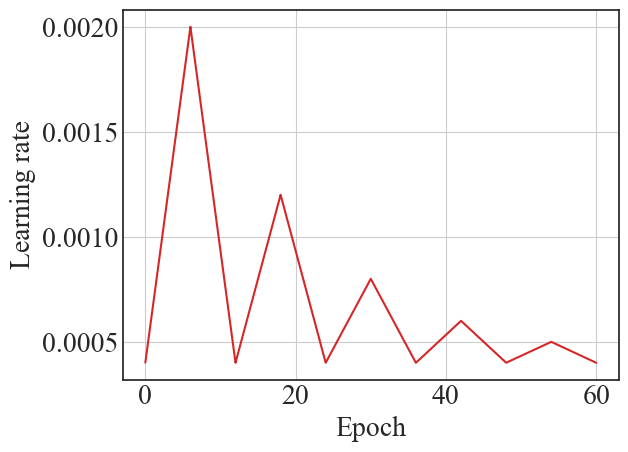

In [15]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 51.583333333333314, 'Epochs')

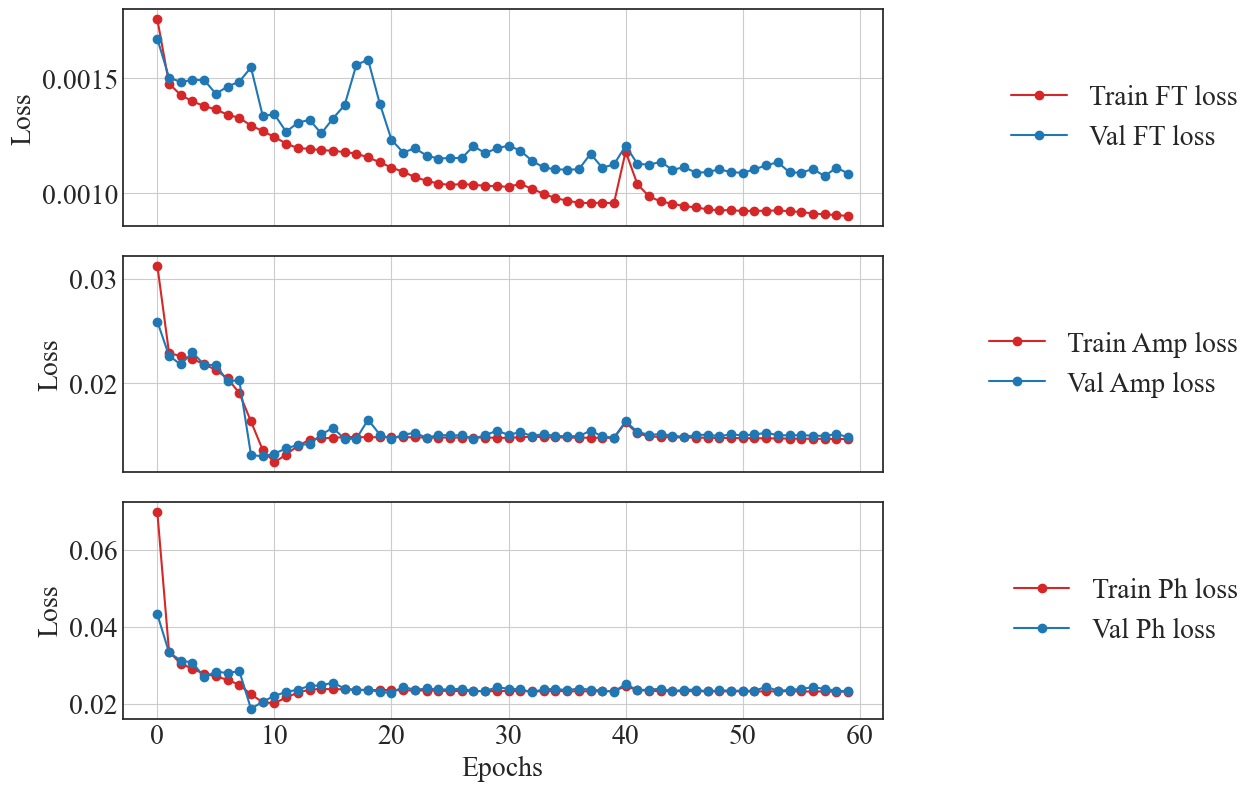

In [16]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Train FT loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Val FT loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")
